In [1]:
from models.pconv_unet import PConvUNet
from utils.preprocessing import Preprocessor

In [2]:
import torch
from PIL import Image
import numpy as np

In [3]:
model_file = "../../_ckpt_epoch_3.ckpt"
device = "cuda"
test_img = "../../Repos/image-inpainting/dataset/test/0000a54dd13a67a7.jpg"
mask_img = "../../Repos/image-inpainting/dataset/irregular_mask/irregular_mask/disocclusion_img_mask/20255.png"

In [4]:
ms = torch.load(model_file)
model_dict = {key.replace("pConvUNet.",""):val for key, val in ms['state_dict'].items()}

In [5]:
pConvUNet = PConvUNet()
pConvUNet.load_state_dict(model_dict)
pConvUNet.to(device)
pConvUNet.eval()

PConvUNet(
  (encoder1): PConvEncoder(
    (pconv): PartialConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (encoder2): PConvEncoder(
    (pconv): PartialConv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (encoder3): PConvEncoder(
    (pconv): PartialConv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (encoder4): PConvEncoder(
    (pconv): PartialConv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (encoder5): PConvEnc

In [6]:
preprocess = Preprocessor("cuda")

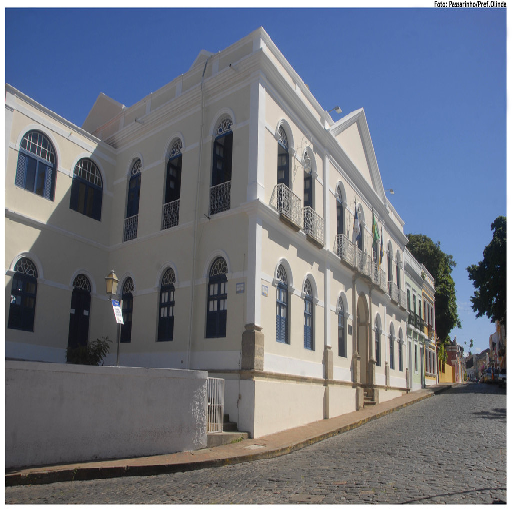

In [7]:
im = Image.open(test_img).resize((512,512)).convert('RGB')
im

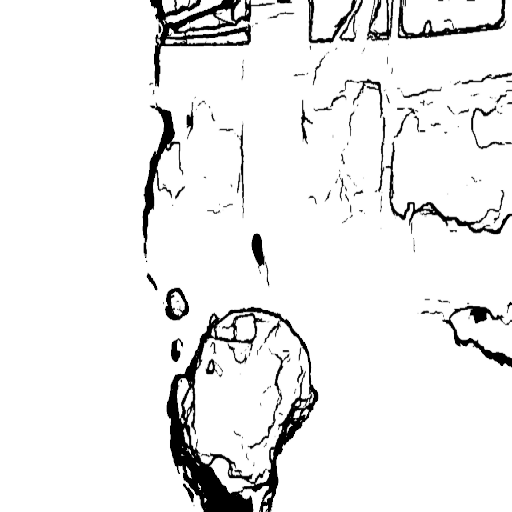

In [8]:
mask_im = Image.open(mask_img).resize((512,512)).convert('RGB')
mask_im

In [9]:
image = np.array(im) /255
image = np.expand_dims(image, axis=0)

mask = np.array(mask_im) /255
mask = np.expand_dims(mask, axis=0)

masked_img = np.copy(np.array(im) /255)
masked_img[(np.array(mask_im) > 1).astype(np.uint8)==0] = 1
masked_img = np.expand_dims(masked_img, axis=0)

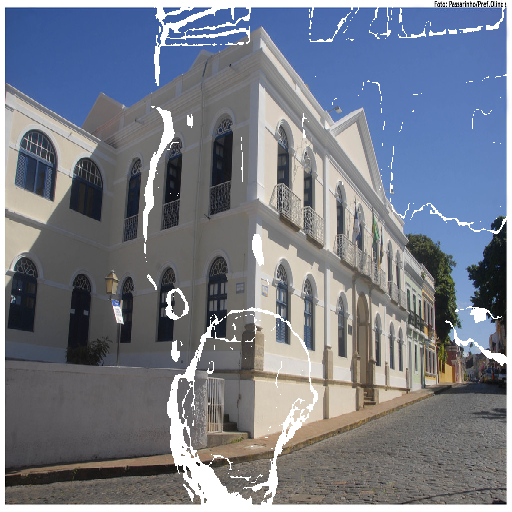

In [10]:
Image.fromarray(np.uint8(masked_img[0]*255))

In [11]:
tensor_img = torch.tensor(image).to(device)
tensor_mask = torch.tensor(mask).to(device)
tensor_masked_img = torch.tensor(masked_img).to(device)

In [12]:
img_tensor = preprocess.normalize(tensor_img.type(torch.float))
mask_tensor = tensor_mask.type(torch.float).transpose(1, 3)
masked_img_tensor = preprocess.normalize(tensor_masked_img.type(torch.float))

In [13]:
res = pConvUNet(masked_img_tensor,mask_tensor)
res = np.clip(preprocess.unnormalize(res).detach().cpu().numpy(),0,1)
original_img = np.clip(preprocess.unnormalize(masked_img_tensor).detach().cpu().numpy(),0,1)
combined_img = np.concatenate((original_img[0], res[0]))
saveImg = Image.fromarray((combined_img*255).astype(np.uint8))

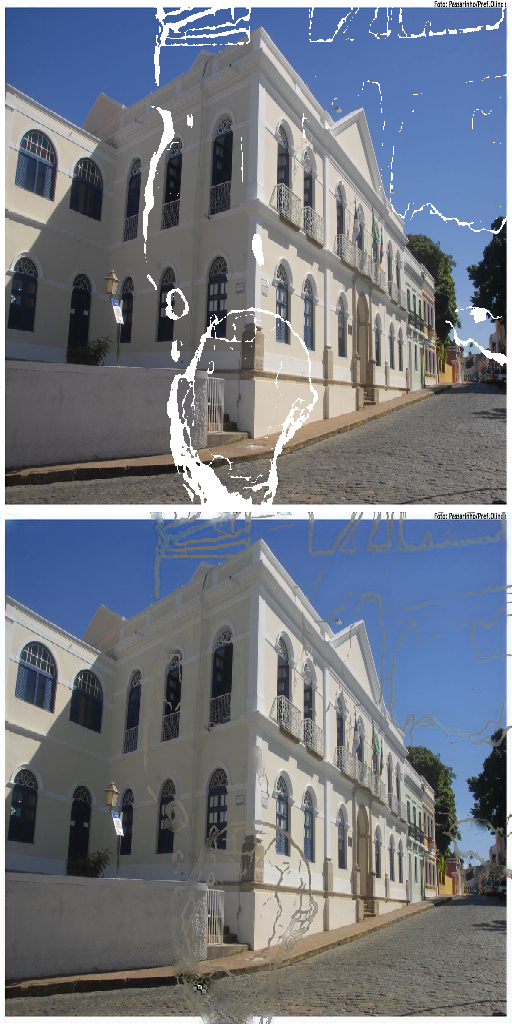

In [14]:
saveImg